## Set up Google Colab environment

In [0]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  ## Specify a directory in Google Drive
  dir = '/content/drive/My Drive/Colab Notebooks/Keras_CIFAR10'
  os.chdir(dir)
  #os.getcwd()
  #os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if colab:
  ## Check the uptime. (Google Colab reboots every 12 hours)
  !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
  ## Check the GPU info
  !nvidia-smi
  ## Check the Python version
  !python --version

Uptime is 3.86339 hours (13908.22 sec)
Fri Jan 25 17:09:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                     

## Import modules

In [0]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## Set up data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
num_classes = 10
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
input_shape = x_train.shape[1:]

## Define model

In [0]:
# Returns a short sequential model
def create_model(input_shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  # initiate RMSprop optimizer
  opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model

## Fit model

In [0]:
### If resume_if_possible = True, fitting can resume using a model file. 
resume_if_possible = True 

### Set resume_if_possible = False to force fitting from scratch.
#resume_if_possible = False 

epochs = 100
log_file_path = 'training_log.csv'
model_file_path = 'model_epoch{epoch:06d}.hdf5'

model_file_list = glob.glob('model_epoch*.hdf5')
log_file_list = glob.glob(log_file_path)

if resume_if_possible:
  resume_flag = (len(model_file_list) >= 1) 
  
if not resume_if_possible:
  resume_flag = False
  for f in model_file_list:
    os.remove(f)

if resume_flag:
  latest_model_file = model_file_list[-1]
  latest_epoch = int(latest_model_file[len('model_epoch'):-len('.hdf5')])
  ## Load the saved model
  model = keras.models.load_model(latest_model_file)

  score = model.evaluate(x_test,y_test, verbose=0)
  print('Use {} to resume fitting. \nTest loss: {}   Test accuracy: {}'.format(latest_model_file, score[0], score[1]))

  if len(model_file_list) >= 2:
    ## Delete all model files excpet the latest to save space
    for f in model_file_list[:-1]:
      os.remove(f)

if not resume_flag:
  latest_epoch = 0
  ## Create a basic model instance
  model = create_model(input_shape)
  for f in log_file_list:
    os.remove(f)

model.summary()

## Create checkpoint callback
check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = model_file_path, 
                                                 monitor = 'val_acc',
                                                 verbose=1,
                                                 save_best_only = True,
                                                 mode='auto',
                                                 save_weights_only=False,
                                                 period = 1)

## Create early stopping callback
early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                   min_delta=0, 
                                                   patience=5, 
                                                   verbose=1, 
                                                   mode='auto', 
                                                   baseline=None)

## Create CSV logger callback
csv_logger_ = tf.keras.callbacks.CSVLogger(filename = log_file_path, separator=',',
                                           append = resume_flag)

## Fit 
model.fit(x_train, y_train, epochs = epochs, initial_epoch = latest_epoch,
          validation_data = (x_test,y_test), shuffle = True,
          callbacks = [check_point_, early_stopping_, csv_logger_])

## Remove duplicates as save_best_only option of checkpoint is set to True.
pd.options.display.max_rows = 8
log_df = pd.read_csv(log_file_path)
log_wo_dup_df = log_df.drop_duplicates(subset = ['epoch'], keep='last').reset_index(drop=True)
log_wo_dup_df.to_csv((log_file_path[:-len('.csv')] + '_processed.csv'), index=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 15, 15, 64)        0         
__________

In [0]:
### Clean up
model_file_list = glob.glob('model_epoch*.hdf5')  
if len(model_file_list) >= 2:
  ## Delete all model files excpet the latest one to save space
  for f in model_file_list[:-1]:
    os.remove(f)

,epoch,acc,loss,val_acc,val_loss
0,0,0.40672,1.650632,0.4843,1.433208
1,1,0.52212,1.343988,0.5525,1.261863
2,2,0.57650,1.197377,0.5540,1.299413
3,3,0.62144,1.084134,0.6220,1.091660
...,...,...,...,...,...
20,20,0.93030,0.210556,0.7309,1.051481
21,21,0.94218,0.178960,0.7289,1.095149
22,22,0.95226,0.150979,0.7266,1.211292
23,23,0.95928,0.126168,0.7203,1.272289


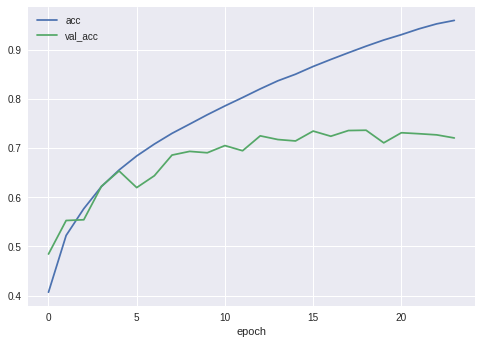

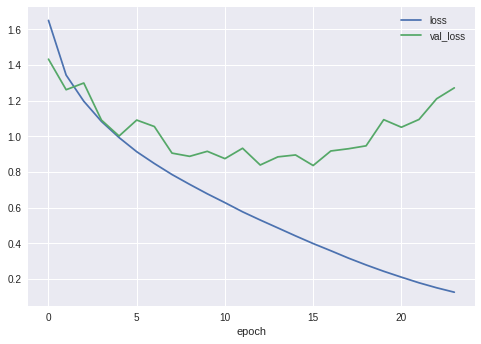

In [0]:
display(log_wo_dup_df)
log_wo_dup_df[['epoch', 'acc', 'val_acc']].plot(x='epoch')
log_wo_dup_df[['epoch', 'loss', 'val_loss']].plot(x='epoch')

References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint